# DS 1003 Homework 3

### Name: Shuwen Shen
### NetID: ss13289

### Ridge Regression

### 1

In [747]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.optimize import minimize

from sklearn.base import BaseEstimator, RegressorMixin,clone
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import confusion_matrix

from load_data import load_problem


PICKLE_PATH = 'lasso_data.pickle'

In [7]:
#load data 

x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(PICKLE_PATH)
X_train = featurize(x_train)
X_val = featurize(x_val)

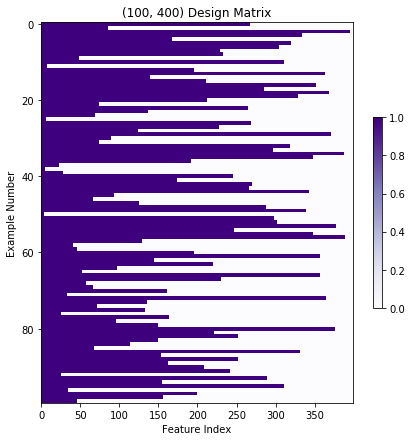

In [8]:
#Visualize training data

fig, ax = plt.subplots(figsize = (7,7))
ax.set_title("({0}, {1}) Design Matrix".format(X_train.shape[0], X_train.shape[1]))
ax.set_xlabel("Feature Index")
ax.set_ylabel("Example Number")
temp = ax.imshow(X_train, cmap=plt.cm.Purples, aspect="auto")
plt.colorbar(temp, shrink=0.5);

In [9]:
# class for ridge regression

class RidgeRegression(BaseEstimator, RegressorMixin):
	""" ridge regression"""

	def __init__(self, l2reg=1):
		if l2reg < 0:
			raise ValueError('Regularization penalty should be at least 0.')
		self.l2reg = l2reg

	def fit(self, X, y=None):
		n, num_ftrs = X.shape
		# convert y to 1-dim array, in case we're given a column vector
		y = y.reshape(-1)
		def ridge_obj(w):
			predictions = np.dot(X,w)
			residual = y - predictions
			empirical_risk = np.sum(residual**2) / n
			l2_norm_squared = np.sum(w**2)
			objective = empirical_risk + self.l2reg * l2_norm_squared
			return objective
		self.ridge_obj_ = ridge_obj

		w_0 = np.zeros(num_ftrs)
		self.w_ = minimize(ridge_obj, w_0).x
		return self

	def predict(self, X, y=None):
		try:
			getattr(self, "w_")
		except AttributeError:
			raise RuntimeError("You must train classifer before predicting data!")
		return np.dot(X, self.w_)

	def score(self, X, y):
		# Average square error
		try:
			getattr(self, "w_")
		except AttributeError:
			raise RuntimeError("You must train classifer before predicting data!")
		residuals = self.predict(X) - y
		return np.dot(residuals, residuals)/len(y)

In [283]:
def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):

	# Fit with sklearn -- need to multiply l2_reg by sample size, since their
	# objective function has the total square loss, rather than average square
	# loss.
	n = X_train.shape[0]
	sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
	sklearn_ridge.fit(X_train, y_train)
	sklearn_ridge_coefs = sklearn_ridge.coef_

	# Now run our ridge regression and compare the coefficients to sklearn's
	ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
	ridge_regression_estimator.fit(X_train, y_train)
	our_coefs = ridge_regression_estimator.w_

	print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

In [284]:
compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1.5)

Hoping this is very close to 0:4.6884282980897267e-11


In [10]:
# Grid Search to Tune Hyperparameter

default_params = np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3))))

def do_grid_search_ridge(X_train, y_train, X_val, y_val, params = default_params):

	X_train_val = np.vstack((X_train, X_val))
	y_train_val = np.concatenate((y_train, y_val))
	val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

	param_grid = [{'l2reg':params}]

	ridge_regression_estimator = RidgeRegression()
	grid = GridSearchCV(ridge_regression_estimator,
						param_grid,
						return_train_score=True,
						cv = PredefinedSplit(test_fold=val_fold),
						refit = True,
						scoring = make_scorer(mean_squared_error,
											  greater_is_better = False))
	grid.fit(X_train_val, y_train_val)

	df = pd.DataFrame(grid.cv_results_)
	# Flip sign of score back, because GridSearchCV likes to maximize,
	# so it flips the sign of the score if "greater_is_better=FALSE"
	df['mean_test_score'] = -df['mean_test_score']
	df['mean_train_score'] = -df['mean_train_score']
	cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
	df_toshow = df[cols_to_keep].fillna('-')
	df_toshow = df_toshow.sort_values(by=["param_l2reg"])
	return grid, df_toshow

In [11]:
grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)

In [11]:
results

,param_l2reg,mean_test_score,mean_train_score
0,0.000001,0.172579,0.006752
1,0.000010,0.172464,0.006752
2,0.000100,0.171345,0.006774
3,0.001000,0.162705,0.008285
4,0.010000,0.141887,0.032767
5,0.100000,0.144566,0.094953
6,1.000000,0.171068,0.197694
7,1.300000,0.179521,0.216591
8,1.600000,0.187993,0.233450
9,1.900000,0.196361,0.248803


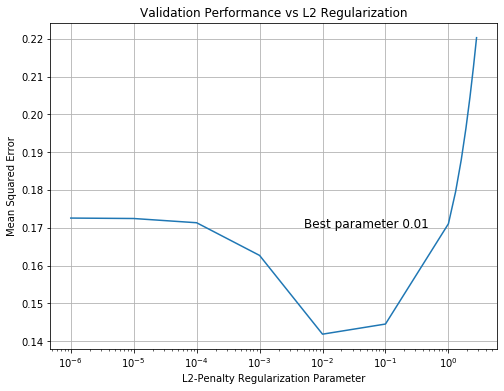

In [12]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots(figsize = (8,6))
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.semilogx(results["param_l2reg"], results["mean_test_score"])
ax.text(0.005,0.17,"Best parameter {0}".format(grid.best_params_['l2reg']), fontsize = 12);

We choose $\lambda=0.01$ since it reaches the lowest mean squared error.

### 2

In [833]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

pred_fns.append({"name": "Target Function", "coefs": coefs_true, "preds": target_fn(x)})

l2regs = [0, grid.best_params_['l2reg'], 1]
X = featurize(x)
for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(X_train, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                     "coefs":ridge_regression_estimator.w_,
                     "preds": ridge_regression_estimator.predict(X) })

In [14]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):

	fig, ax = plt.subplots(figsize = (12,8))
	ax.set_xlabel('Input Space: [0,1)')
	ax.set_ylabel('Action/Outcome Space')
	ax.set_title("Prediction Functions")
	plt.scatter(x_train, y_train, color="k", label='Training data')
	for i in range(len(pred_fns)):
		ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"])
	legend = ax.legend(loc=legend_loc, shadow=True)
	return fig

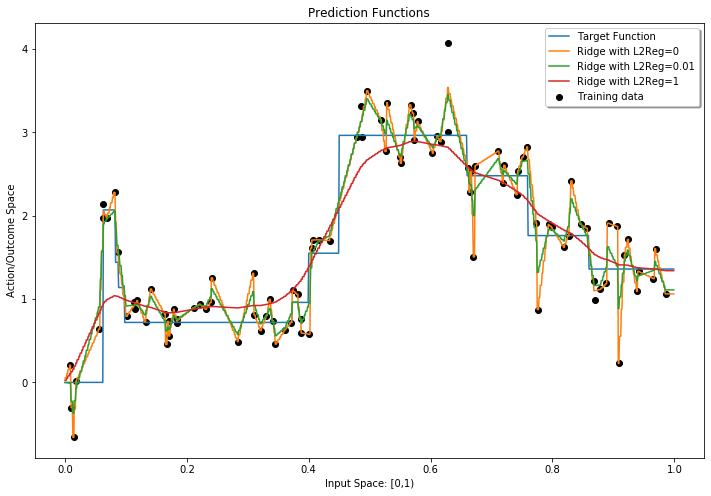

In [15]:
plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best");

In [20]:
def compare_parameter_vectors(pred_fns):

	fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize = (20,20))
	num_ftrs = len(pred_fns[0]["coefs"])
	for i in range(len(pred_fns)):
		title = pred_fns[i]["name"]
		coef_vals = pred_fns[i]["coefs"]
		axs[i].bar(range(num_ftrs), coef_vals, color = "tab:purple")
		axs[i].set_xlabel('Feature Index')
		axs[i].set_ylabel('Parameter Value')
		axs[i].set_title(title)

	fig.subplots_adjust(hspace=0.4)
	return fig

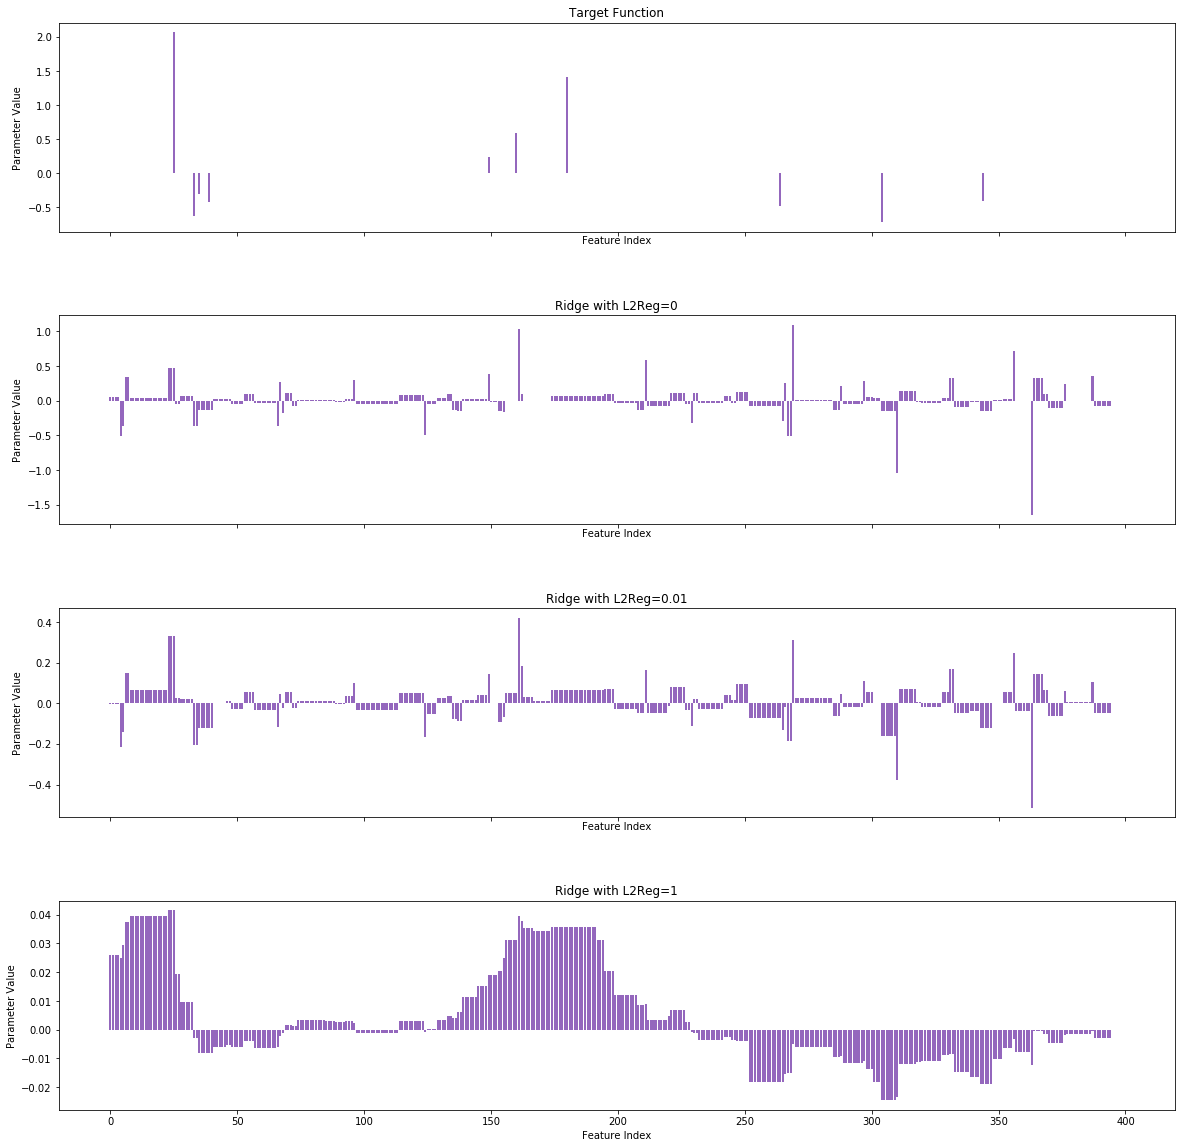

In [22]:
compare_parameter_vectors(pred_fns);

From the plots above, we could see that the target function only has ten non-zero parameters while the others have more than 10 non-zero parameters. As we impose different L2_reg from 0 to 1, we could see that the number of non-zero parameters becomes larger and the parameters become less sparse, which means that ridge regression does not encourage sparsity.

The scale of the coefficients decreases with L2_reg increases from  0 to 1.

Ridge regression fit with L2_reg =1 has similar most weight coefficient with the target function at index around 25 and the with L2_reg = 0.01 and 0 have similar most weight coefficient at index around 370.

### 3

In [181]:
def plot_confusion_matrix(cm, title, classes):      
	 plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Purples)     
	 plt.title(title)       
	 plt.colorbar()     
	 tick_marks = np.arange(len(classes))       
	 plt.xticks(tick_marks, classes, rotation=45)       
	 plt.yticks(tick_marks, classes)  

	 thresh = cm.max() / 2.        
	 for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):     
		 plt.text(j, i, format(cm[i, j], 'd'),      
				  horizontalalignment="center",     
				  color="white" if cm[i, j] > thresh else "black")      

	 plt.tight_layout()        
	 plt.ylabel('True label')       
	 plt.xlabel('Predicted label')
	 plt.ylim(1.5,-0.5)

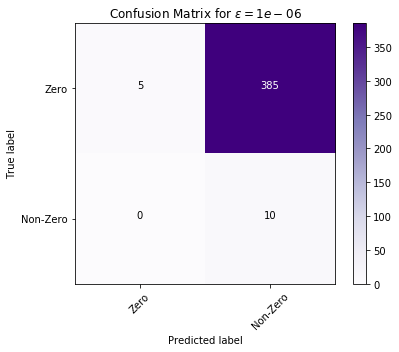

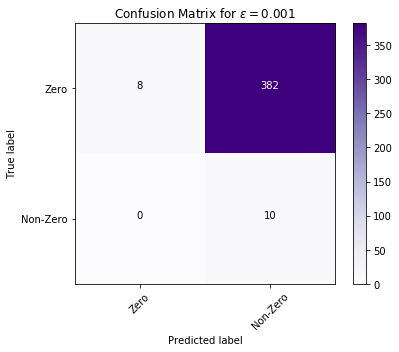

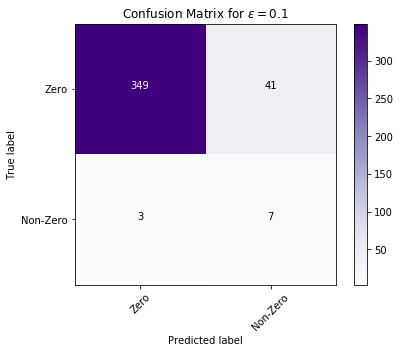

In [182]:
bin_coefs_true=np.where(pred_fns[0]['coefs']== 0, 0, 1)# your code goes here
eps_list = [1e-6,1e-3,1e-1]# your code goes here
for eps in eps_list:
    bin_coefs_estimated = np.where(abs(pred_fns[2]['coefs'])<eps, 0, 1)# your code goes here  
    cnf_matrix = confusion_matrix(bin_coefs_true, bin_coefs_estimated)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, title="Confusion Matrix for $\epsilon = {}$".format(eps), classes=["Zero", "Non-Zero"])

### Lasso Regression

### 1

$\displaystyle J(w)=\displaystyle\sum_{i=1}^{m}(h_w (x_i)-y_i)^2 + \lambda ||w||_1 = ||Xw-y||^2 + \lambda ||w||_1 $

$\displaystyle a_j = 2\cdot X_j^T X_j$

$\displaystyle c_j = 2\cdot X_j^T(y-Xw+w_jx_j)$

### 2

#### Coordinate Descent for Lasso Regression (Shooting Algorithm)

For the shooting algorithm, we need to compute the Lasso Regression objective for the stopping condition. Moreover we need a threshold function at each iteration along with the solution to Ridge Regression for initial weights.  

In [303]:
def soft_threshold(a, delta):
    ####
    # your code goes here
    if a < - delta:
        return (a + delta)
    elif a >  delta:
        return (a - delta)
    else: 
        return 0
    ####
    
def compute_sum_sqr_loss(X, y, w):
    ####
    # your code goes here
    predictions = np.dot(X,w)
    residual = y - predictions
    sum_sqr_loss = np.sum(residual**2) 
    return sum_sqr_loss
    ####
    
def compute_lasso_objective(X, y, w, l1_reg=0):
    ####
    # your code goes here
    l1_norm = np.sum(abs(w))
    objective = compute_sum_sqr_loss(X, y, w) + l1_reg * l1_norm
    return objective
    ####
    
def get_ridge_solution(X, y, l2_reg):
    ####
    # your code goes here
    ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
    ridge_regression_estimator.fit(X, y)
    sol = ridge_regression_estimator.w_
    return sol
    ####

In [512]:
w_ridge=get_ridge_solution(X_train, y_train, 1)

In [403]:
range(X.shape[1])

range(0, 4)

In [476]:
def shooting_algorithm(X, y, w0=None, l1_reg = 1., max_num_epochs = 1000, min_obj_decrease=1e-8, random=False):
    if w0 is None:
        w = np.zeros(X.shape[1])
    else:
        w = np.copy(w0)
    d = X.shape[1] #n features
    epoch = 0
    obj_val = compute_lasso_objective(X, y, w, l1_reg)
    obj_decrease = min_obj_decrease + 1.
    while (obj_decrease>min_obj_decrease) and (epoch<max_num_epochs):
        obj_old = obj_val
        # Cyclic coordinates descent
        coordinates = range(d)
        # Randomized coordinates descent
        if random:
            coordinates = np.random.permutation(d)
        for j in coordinates:
            ####
            # your code goes here
            X_j=X[:,j]
            a_j=2*np.dot(X_j.T,X_j)#scaler
            
            c_j=2*np.dot(X_j.T,y-np.dot(X,w)+w[j]*X_j)
            
            if a_j==0 and c_j==0:
                w[j]=0
            else:
                w[j]=soft_threshold(c_j/a_j, l1_reg/a_j)
            
            ####
            
        obj_val = compute_lasso_objective(X, y, w, l1_reg)
        
        obj_decrease = obj_old - obj_val
        epoch += 1
    print("Ran for "+str(epoch)+" epochs. " + 'Lowest loss: ' + str(obj_val))
    return w

#### Class for Lasso Regression 

In [691]:
class LassoRegression(BaseEstimator, RegressorMixin):
    """ Lasso regression"""
    def __init__(self, l1_reg=1.0, randomized=False):
        if l1_reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l1_reg = l1_reg
        self.randomized = randomized


    def fit(self, X, y, max_epochs = 1000, coef_init=None):
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        if coef_init is None:
            coef_init = get_ridge_solution(X,y, self.l1_reg)
        
        ####
        # your code goes here
        n, num_ftrs = X.shape
        def lasso_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            sum_sqr_loss = np.sum(residual**2) 
            l1_norm = numpy.linalg.norm(w,1)
            objective = sum_sqr_loss + self.l1_reg * l1_norm
            return objective       
        self.lasso_obj_ = lasso_obj
        
        self.w_ = shooting_algorithm(X, y, w0=get_ridge_solution(X, y, self.l1_reg), l1_reg = self.l1_reg, max_num_epochs = 1000, min_obj_decrease=1e-8, random=self.randomized)
        ####
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return np.dot(X, self.w_)

    def score(self, X, y):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return compute_sum_sqr_loss(X, y, self.w_)/len(y)

We can compare to the `sklearn` implementation.

In [550]:
def compare_our_lasso_with_sklearn(X_train, y_train, l1_reg=1):
    
    # Fit with sklearn -- need to divide l1_reg by 2*sample size, since they
    # use a slightly different objective function.
    n = X_train.shape[0]
    sklearn_lasso = Lasso(alpha=l1_reg/(2*n), fit_intercept=False, normalize=False)
    sklearn_lasso.fit(X_train, y_train)
    sklearn_lasso_coefs = sklearn_lasso.coef_
    sklearn_lasso_preds = sklearn_lasso.predict(X_train)

    # Now run our lasso regression and compare the coefficients to sklearn's
    
    ####
    # your code goes here
    lasso_regression_estimator = LassoRegression(l1_reg=l1_reg)
    lasso_regression_estimator.fit(X_train, y_train)
    our_coefs = lasso_regression_estimator.w_
    lasso_regression_preds=lasso_regression_estimator.predict(X_train, y_train)
    ####

    # Let's compare differences in predictions
    print("Hoping this is very close to 0 (predictions): {}".format( np.mean((sklearn_lasso_preds - lasso_regression_preds)**2)))
    # Let's compare differences parameter values
    print("Hoping this is very close to 0: {}".format(np.sum((our_coefs - sklearn_lasso_coefs)**2)))

In [507]:
compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1.5)

Hoping this is very close to 0:4.6884282980897267e-11


In [508]:
compare_our_lasso_with_sklearn(X_train, y_train, l1_reg=1.5)

Ran for 811 epochs. Lowest loss: 19.508009386279696
Hoping this is very close to 0 (predictions): 4.4723994410690814e-07
Hoping this is very close to 0: 0.00010389953150993696


In [509]:
compare_our_lasso_with_sklearn(X_train, y_train, l1_reg=1)

Ran for 824 epochs. Lowest loss: 16.19773797187303
Hoping this is very close to 0 (predictions): 3.55488803386595e-07
Hoping this is very close to 0: 8.306670429851527e-05


In [510]:
compare_our_lasso_with_sklearn(X_train, y_train, l1_reg=0.1)

Ran for 1000 epochs. Lowest loss: 3.9049775016337263
Hoping this is very close to 0 (predictions): 2.2039548451201195e-08
Hoping this is very close to 0: 6.037081354337262e-06


We use l1_reg=1, so we choose $\lambda$=1

) zero weight init and random coordinate descent

2) murphys weight init and random descent

3) zero weight and cyclic 

4) murphys and cyclic

#### Compare performance of cyclic coordinate descent to randomized coordinate descent

In [545]:
# zero weight and cyclic
import time

start_time = time.time()

lasso_regression_estimator = LassoRegression(l1_reg=1,randomized=False)
lasso_regression_estimator.fit(X_train, y_train)
our_coefs = lasso_regression_estimator.w_
lasso_regression_preds=lasso_regression_estimator.predict(X_train, y_train)

end_time = time.time()

print("run_time of ero weight and cyclic: %f" % (end_time - start_time))

Ran for 824 epochs. Lowest loss: 16.19773797187303
run_time of ero weight and cyclic: 4.280857


In [546]:
compute_lasso_objective(X_val,y_val,our_coefs,l1_reg=1)

158.0402105990854

In [547]:
# zero weight and random
start_time = time.time()

lasso_regression_estimator = LassoRegression(l1_reg=1,randomized=True)
lasso_regression_estimator.fit(X_train, y_train)
our_coefs = lasso_regression_estimator.w_
lasso_regression_preds=lasso_regression_estimator.predict(X_train, y_train)

end_time = time.time()

print("run_time of zero weight and random: %f" % (end_time - start_time))

Ran for 824 epochs. Lowest loss: 16.19773797187303
run_time of zero weight and random: 4.129931


In [548]:
compute_lasso_objective(X_val,y_val,our_coefs,l1_reg=1)

158.0402105990854

The performance of randomized coordinate descent is slight better.

#### Compare solutions for starting at 0 and starting at the ridge regression solution

In [555]:
# morphys weight and cyclic
start_time = time.time()
lasso_regression_estimator = LassoRegression(l1_reg=1,randomized=False)
lasso_regression_estimator.fit(X_train, y_train)
our_coefs = lasso_regression_estimator.w_
lasso_regression_preds=lasso_regression_estimator.predict(X_train, y_train)
end_time = time.time()

print("run_time of morphys weight and random: %f" % (end_time - start_time))

Ran for 818 epochs. Lowest loss: 16.197737979050906
run_time of morphys weight and random: 4.328894


In [556]:
compute_lasso_objective(X_val,y_val,our_coefs,l1_reg=1)

129.07012780237923

In [557]:
# morphys weight and random
start_time = time.time()
lasso_regression_estimator = LassoRegression(l1_reg=1,randomized=True)
lasso_regression_estimator.fit(X_train, y_train)
our_coefs = lasso_regression_estimator.w_
lasso_regression_preds=lasso_regression_estimator.predict(X_train, y_train)
end_time = time.time()

print("run_time of morphys weight and cyclic: %f" % (end_time - start_time))

Ran for 818 epochs. Lowest loss: 16.197737979050906
run_time of morphys weight and cyclic: 4.155429


In [558]:
compute_lasso_objective(X_val,y_val,our_coefs,l1_reg=1)

129.07012780237923

The performance of morphys weight and cyclic is better than randomized.

The solution attained for starting at the ridge regression solution by Murphy has lower validation loss.

### 3

#### Grid Search to Tune Hyperparameter

In [692]:
default_params = np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3))))
def do_grid_search_lasso(X_train, y_train, X_val, y_val,params = default_params):
    ####
    ## your code goes here
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    param_grid = [{'l1_reg':params}]

    lasso_regression_estimator = LassoRegression(randomized=True)
    grid = GridSearchCV(lasso_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize,
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l1_reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l1_reg"])
    return grid, df_toshow
    ####

In [770]:
grid, results = do_grid_search_lasso(X_train, y_train, X_val, y_val)

Ran for 57 epochs. Lowest loss: 0.6752231614000815
Ran for 191 epochs. Lowest loss: 0.6755586588880127
Ran for 589 epochs. Lowest loss: 0.6789110643172016
Ran for 1000 epochs. Lowest loss: 0.7123845987775024
Ran for 1000 epochs. Lowest loss: 1.042269840883376
Ran for 1000 epochs. Lowest loss: 3.904976581678644
Ran for 713 epochs. Lowest loss: 16.197738040274015
Ran for 691 epochs. Lowest loss: 18.20873769856434
Ran for 687 epochs. Lowest loss: 20.14633205304427
Ran for 664 epochs. Lowest loss: 22.016046596642717
Ran for 692 epochs. Lowest loss: 23.818255230000055
Ran for 671 epochs. Lowest loss: 25.559311115079208
Ran for 674 epochs. Lowest loss: 27.24293397942499
Ran for 1000 epochs. Lowest loss: 89.2672440958675


In [771]:
results

,param_l1_reg,mean_test_score,mean_train_score
0,0.000001,0.172586,0.006752
1,0.000010,0.172577,0.006752
2,0.000100,0.172565,0.006752
3,0.001000,0.172243,0.006752
4,0.010000,0.170487,0.006808
5,0.100000,0.159665,0.011146
6,1.000000,0.126417,0.091951
7,1.300000,0.128030,0.096655
8,1.600000,0.128294,0.099936
9,1.900000,0.126903,0.103895


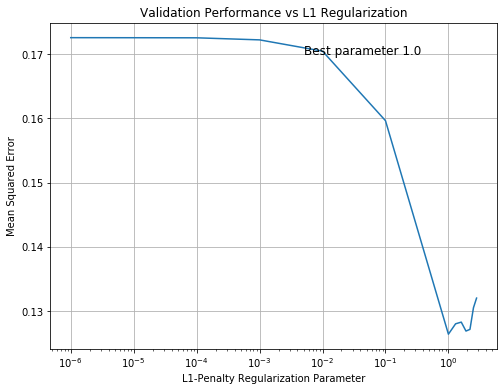

In [772]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots(figsize = (8,6))
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.semilogx(results["param_l1_reg"], results["mean_test_score"])
ax.text(0.005,0.17,"Best parameter {0}".format(grid.best_params_['l1_reg']), fontsize = 12);

#### Comparing to the Target Function

Let's plot prediction functions and compare coefficients for several fits and the target function.


Let's create a list of dicts called `pred_fns`. Each dict has a "name" key and a
"preds" key. The value corresponding to the "preds" key is an array of
predictions corresponding to the input vector x. x_train and y_train are
the input and output values for the training data

In [696]:
grid.best_params_['l1_reg']

1.0

In [697]:
default_params

array([1.0e-06, 1.0e-05, 1.0e-04, 1.0e-03, 1.0e-02, 1.0e-01, 1.0e+00,
       1.3e+00, 1.6e+00, 1.9e+00, 2.2e+00, 2.5e+00, 2.8e+00])

In [698]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))

pred_fns.append({"name": "Target Function", "coefs": coefs_true, "preds": target_fn(x)})

l1regs = default_params
X = featurize(x)
for l1_reg in l1regs:
    lasso_regression_estimator = LassoRegression(l1_reg=l1_reg)
    lasso_regression_estimator.fit(X_train, y_train)
    name = "L1Reg="+str(l1_reg)
    pred_fns.append({"name":name,
                     "coefs":lasso_regression_estimator.w_,
                     "preds": lasso_regression_estimator.predict(X) })

Ran for 76 epochs. Lowest loss: 0.6752230328858336
Ran for 185 epochs. Lowest loss: 0.6755582975962571
Ran for 490 epochs. Lowest loss: 0.6789105270159282
Ran for 1000 epochs. Lowest loss: 0.712514438605663
Ran for 1000 epochs. Lowest loss: 1.04710006618864
Ran for 1000 epochs. Lowest loss: 3.904984445422463
Ran for 818 epochs. Lowest loss: 16.197737979050906
Ran for 810 epochs. Lowest loss: 18.20873759934751
Ran for 799 epochs. Lowest loss: 20.146331963438826
Ran for 786 epochs. Lowest loss: 22.016046431278312
Ran for 800 epochs. Lowest loss: 23.81825515961203
Ran for 829 epochs. Lowest loss: 25.559310942744595
Ran for 832 epochs. Lowest loss: 27.242933942453597


In [699]:
label=['Target Function','1.0e-06','1.0e-05','1.0e-04','1.0e-03','1.0e-02','1.0e-01','1.0','1.3','1.6','1.9','2.2','2.5','2.8']

In [700]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):

    fig, ax = plt.subplots(figsize = (12,8))
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, color="k", label='Training data')
    ax.plot(x, pred_fns[0]["preds"], label=label[0])
    for i in range(1,len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label='L1_reg= '+label[i])
    legend = ax.legend(loc=legend_loc, shadow=True,fontsize='small',ncol=2)
    return fig

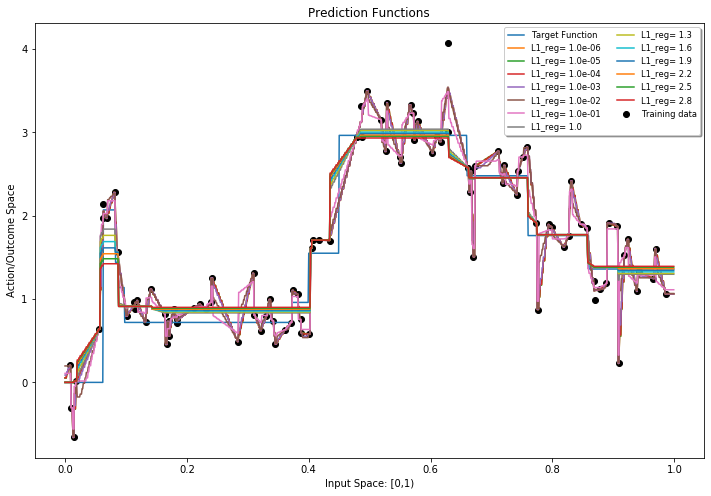

In [701]:
plot_prediction_functions(x, pred_fns, x_train, y_train);

#### Visualizing the Weights

In [735]:
def compare_parameter_vectors(pred_fns):

    fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize = (20,20))
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = label[i]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals, color = "tab:purple")
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title('L1_reg ='+title,fontsize=10)

    fig.subplots_adjust(hspace=0.6)
    return fig

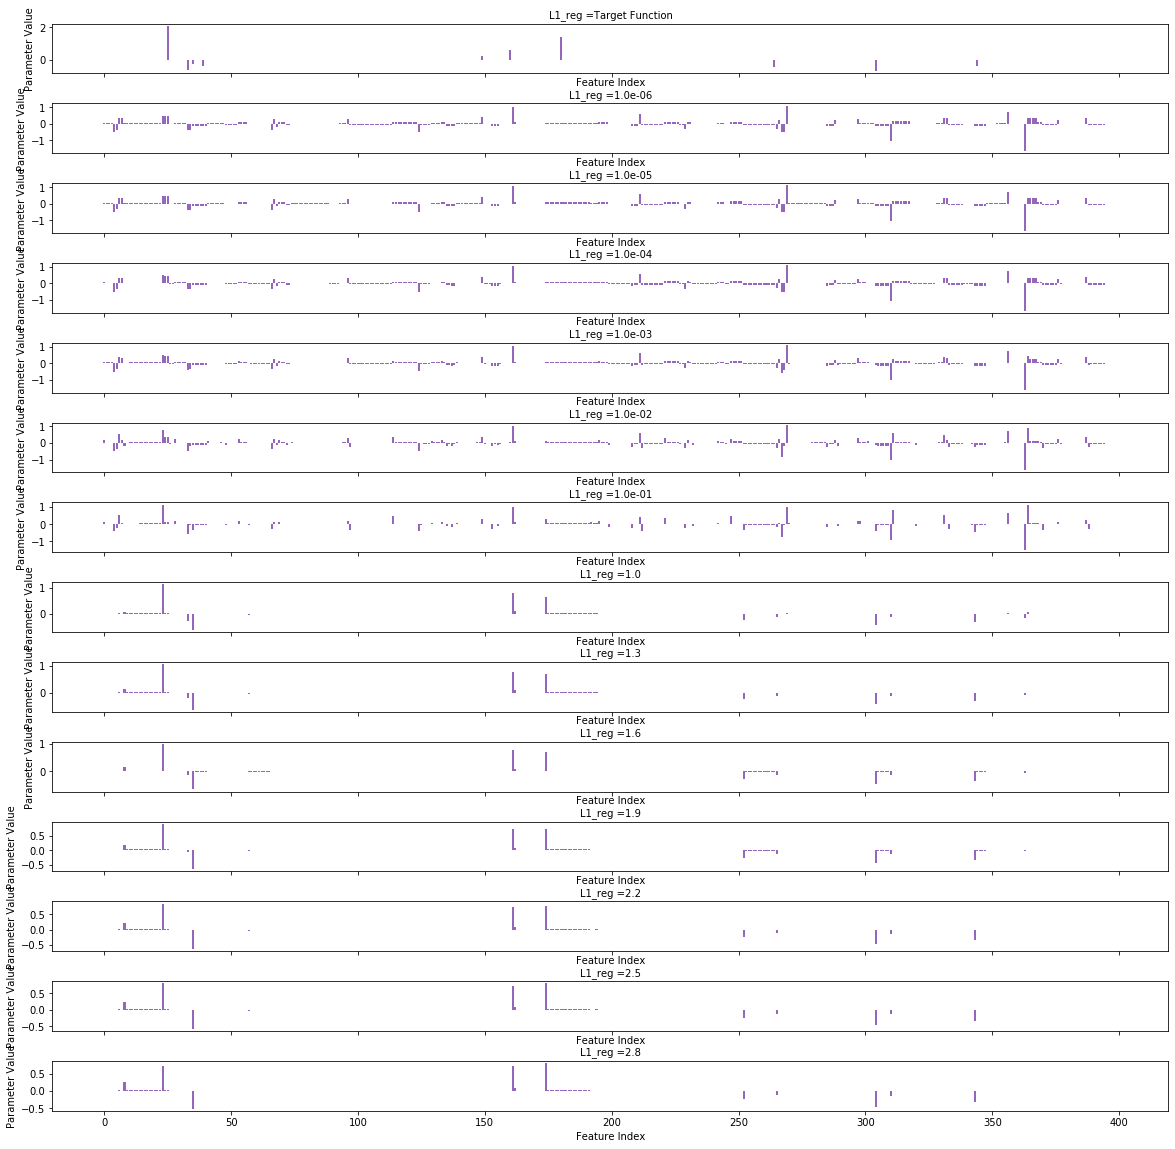

In [736]:
compare_parameter_vectors(pred_fns);

From the plot of our target function, we could see that we only have 10 non-zero coefficients. When L1_reg increases, the sparsity increases, which is different to the ridge regression.

we choose $\lambda = 1.0$ and its corresponding mean_test_score=0.125804.

### 4

#### Continuation Method

We compute the largest value of $\lambda$ for which the weights can be nonzero.

In [748]:
def get_lambda_max_no_bias(X, y):
    return 2 * np.max(np.abs(np.dot(y, X)))

Use homotopy method to compute regularization path for LassoRegression.

In [753]:
class LassoRegularizationPath:
    def __init__(self, estimator, tune_param_name):
        self.estimator = estimator
        self.tune_param_name = tune_param_name

    def fit(self, X, y, reg_vals, coef_init=None, warm_start=True):
        # reg_vals is a list of regularization parameter values to solve for.
        # Solutions will be found in the order given by reg_vals.

        #convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)

        if coef_init is not None:
            coef_init = np.copy(coef_init)

        self.results = []
        for reg_val in reg_vals:
            estimator = clone(self.estimator)

            ####
            ## your code goes here    
            weight=None
            estimator.l1_reg = reg_val 
            estimator.fit(X,y,coef_init = weight) 
            if warm_start:
                weight = estimator.w_
            ####
            
            self.results.append({"reg_val":reg_val, "estimator":estimator})

        return self

    def predict(self, X, y=None):
        predictions = []
        for i in range(len(self.results)):
            preds = self.results[i]["estimator"].predict(X)
            reg_val = self.results[i]["reg_val"]
            predictions.append({"reg_val":reg_val, "preds":preds})
        return predictions

    def score(self, X, y=None):
        scores = []
        for i in range(len(self.results)):
            score = self.results[i]["estimator"].score(X, y)
            reg_val = self.results[i]["reg_val"]
            scores.append({"reg_val":reg_val, "score":score})
        return scores

In [754]:
def do_grid_search_homotopy(X_train, y_train, X_val, y_val,
                            reg_vals=None, w0=None):
    if reg_vals is None:
        lambda_max = get_lambda_max_no_bias(X_train, y_train)
        reg_vals = [lambda_max * (.8**n) for n in range(0, 30)]
    
    ####
    ## your code goes here
    if w0 is None:
        coef_init = np.zeros(X_train.shape[1])
    ####
    
    estimator = LassoRegression()
    lasso_reg_path_estimator = LassoRegularizationPath(estimator, tune_param_name="l1_reg")
    lasso_reg_path_estimator.fit(X_train, y_train,
                                 reg_vals=reg_vals[:], coef_init=w0,
                                 warm_start=True)
    
    return lasso_reg_path_estimator, reg_vals

In [755]:
lasso_reg_path_estimator, reg_vals = do_grid_search_homotopy(X_train, 
                                                             y_train, 
                                                             X_val, 
                                                             y_val, 
                                                             None)

Ran for 2 epochs. Lowest loss: 359.6674002813196
Ran for 595 epochs. Lowest loss: 348.52108633392805
Ran for 648 epochs. Lowest loss: 323.5371648293215
Ran for 603 epochs. Lowest loss: 293.2292649086329
Ran for 738 epochs. Lowest loss: 262.23637334188345
Ran for 739 epochs. Lowest loss: 231.30364706207007
Ran for 741 epochs. Lowest loss: 202.01748558953201
Ran for 742 epochs. Lowest loss: 175.68296893418443
Ran for 744 epochs. Lowest loss: 152.7395224798283
Ran for 745 epochs. Lowest loss: 133.12872422255808
Ran for 746 epochs. Lowest loss: 116.62091783025068
Ran for 746 epochs. Lowest loss: 102.89040534141196
Ran for 747 epochs. Lowest loss: 91.40127987759519
Ran for 747 epochs. Lowest loss: 80.59513458329278
Ran for 747 epochs. Lowest loss: 70.6513115830218
Ran for 747 epochs. Lowest loss: 61.838969281062184
Ran for 747 epochs. Lowest loss: 54.08108000167424
Ran for 746 epochs. Lowest loss: 47.32666932976388
Ran for 741 epochs. Lowest loss: 41.56428606891879
Ran for 764 epochs. Lowes

Text(0.5, 1.0, 'Lasso Regularization Path')

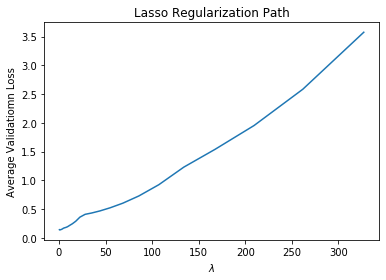

In [762]:
homotopy = lasso_reg_path_estimator.score(X_val, y_val) 
reg_val= [homotopy[i]['reg_val'] for i in range(len(homotopy))] 
val_loss= [homotopy[i]['score'] for i in range(len(homotopy))] 
plt.plot(reg_vals, val_loss)
plt.xlabel('$\lambda$')
plt.ylabel('Average Validatiomn Loss')
plt.title('Lasso Regularization Path')

### 5

### Lasso Regression

In [773]:
mean_y_train = np.mean(y_train)
center_y_train = y_train - mean_y_train
mean_y_val = np.mean(y_val)
center_y_val = y_val-mean_y_val

In [802]:
grid, results_centered = do_grid_search_lasso(X_train, center_y_train, X_val, center_y_val)

Ran for 65 epochs. Lowest loss: 0.6752244802005595
Ran for 194 epochs. Lowest loss: 0.6755708476563466
Ran for 603 epochs. Lowest loss: 0.679032717231548
Ran for 1000 epochs. Lowest loss: 0.7136031281242007
Ran for 1000 epochs. Lowest loss: 1.0545409151613154
Ran for 1000 epochs. Lowest loss: 4.0366928962539514
Ran for 737 epochs. Lowest loss: 17.783523306069394
Ran for 745 epochs. Lowest loss: 20.2423246301038
Ran for 700 epochs. Lowest loss: 22.56783282487074
Ran for 665 epochs. Lowest loss: 24.77468531984495
Ran for 675 epochs. Lowest loss: 26.869031957410414
Ran for 682 epochs. Lowest loss: 28.85722569536235
Ran for 675 epochs. Lowest loss: 30.74298668211194
Ran for 1000 epochs. Lowest loss: 90.97382025996015


In [803]:
results_centered

,param_l1_reg,mean_test_score,mean_train_score
0,0.000001,0.178933,0.006752
1,0.000010,0.178927,0.006752
2,0.000100,0.178974,0.006752
3,0.001000,0.179014,0.006752
4,0.010000,0.178140,0.006807
5,0.100000,0.164487,0.011046
6,1.000000,0.133674,0.091878
7,1.300000,0.133894,0.098881
8,1.600000,0.137398,0.104970
9,1.900000,0.136665,0.111554


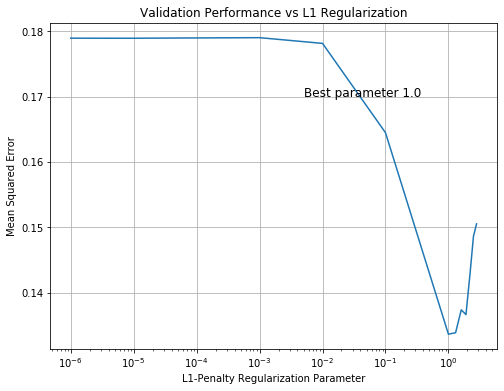

In [807]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots(figsize = (8,6))
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.semilogx(results_centered["param_l1_reg"], results_centered["mean_test_score"])
ax.text(0.005,0.17,"Best parameter {0}".format(grid.best_params_['l1_reg']), fontsize = 12);

In [808]:
def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):

    fig, ax = plt.subplots(figsize = (12,8))
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.scatter(x_train, y_train, color="k", label='Training data')
    ax.plot(x, pred_fns[0]["preds"], label=label[0])
    for i in range(1,len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label='L1_reg= '+label[i])
    legend = ax.legend(loc=legend_loc, shadow=True,fontsize='small',ncol=2)
    return fig

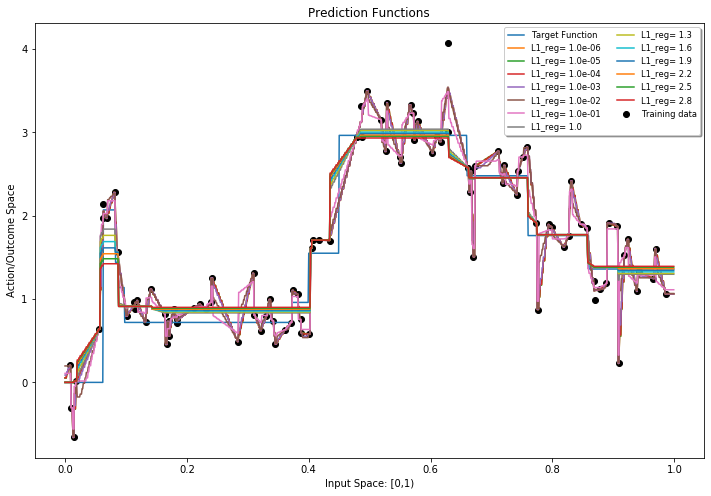

In [809]:
plot_prediction_functions(x, pred_fns, x_train, y_train);

In [810]:
results_centered['mean_test_score_before_centered']=results['mean_test_score']
results_centered

,param_l1_reg,mean_test_score,mean_train_score,mean_test_score_before_centered
0,0.000001,0.178933,0.006752,0.172586
1,0.000010,0.178927,0.006752,0.172577
2,0.000100,0.178974,0.006752,0.172565
3,0.001000,0.179014,0.006752,0.172243
4,0.010000,0.178140,0.006807,0.170487
5,0.100000,0.164487,0.011046,0.159665
6,1.000000,0.133674,0.091878,0.126417
7,1.300000,0.133894,0.098881,0.128030
8,1.600000,0.137398,0.104970,0.128294
9,1.900000,0.136665,0.111554,0.126903


We could see from the table above that for lasso regression, the mean_test_score of all $\lambda$ would increase after centering y.

### Ridge Regression

In [811]:
grid, results_ridge_centered = do_grid_search_ridge(X_train, center_y_train, X_val, center_y_val)

In [812]:
results_ridge_centered

,param_l2reg,mean_test_score,mean_train_score
0,0.000001,0.178923,0.006752
1,0.000010,0.178809,0.006752
2,0.000100,0.177703,0.006773
3,0.001000,0.169136,0.008264
4,0.010000,0.148593,0.032714
5,0.100000,0.168841,0.112772
6,1.000000,0.268280,0.263542
7,1.300000,0.283199,0.282292
8,1.600000,0.296464,0.298239
9,1.900000,0.308748,0.312516


Text(0.005, 0.17, 'Best parameter 0.01')

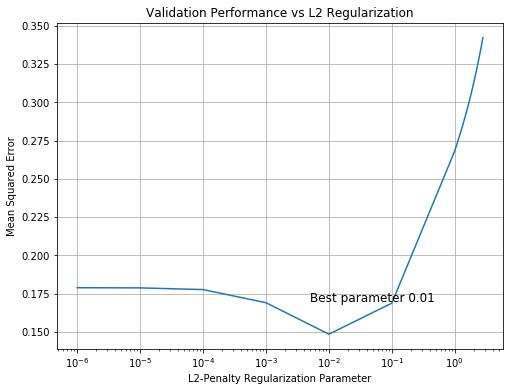

In [813]:
# Plot validation performance vs regularization parameter
fig, ax = plt.subplots(figsize = (8,6))
ax.grid()
ax.set_title("Validation Performance vs L2 Regularization")
ax.set_xlabel("L2-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")
ax.semilogx(results_ridge_centered["param_l2reg"], results_ridge_centered["mean_test_score"])
ax.text(0.005,0.17,"Best parameter {0}".format(grid.best_params_['l2reg']), fontsize = 12)

In [815]:
results_ridge_centered['mean_test_score_before_centered']=results['mean_test_score']
results_ridge_centered

,param_l2reg,mean_test_score,mean_train_score,mean_test_score_before_centered
0,0.000001,0.178923,0.006752,0.172586
1,0.000010,0.178809,0.006752,0.172577
2,0.000100,0.177703,0.006773,0.172565
3,0.001000,0.169136,0.008264,0.172243
4,0.010000,0.148593,0.032714,0.170487
5,0.100000,0.168841,0.112772,0.159665
6,1.000000,0.268280,0.263542,0.126417
7,1.300000,0.283199,0.282292,0.128030
8,1.600000,0.296464,0.298239,0.128294
9,1.900000,0.308748,0.312516,0.126903


We could see from the table above that for ridge regression, the mean_train_score would increase and for $\lambda$ > 0.1 and larger, the mean_test_score would significantly increase more.

### Projected Gradient Descent

### 1

In [816]:
def projection_SGD_split(X, y, theta_positive_0, theta_negative_0, lambda_reg = 1.0, alpha = 0.1, num_iter = 1000):
    m, n = X.shape
    theta_positive = np.zeros(n)
    theta_negative = np.zeros(n)
    theta_positive[0:n] = theta_positive_0
    theta_negative[0:n] = theta_negative_0
    times = 0
    theta = theta_positive - theta_negative
    loss = compute_sum_sqr_loss(X, y, theta)
    loss_change = 1.
    while (loss_change>1e-6) and (times<num_iter):
        loss_old = loss
        for i in range(m):
            ####
            ## your code goes here           
            grad_pos = 2*np.dot(X[i],(np.dot(X[i],theta)) - y[i]) + lambda_reg
            grad_neg = -2*np.dot(X[i],(np.dot(X[i],theta)) - y[i]) + lambda_reg
            theta_positive = theta_positive - alpha * grad_pos
            thets_negative = theta_negative - alpha * grad_neg
            
            theta_positive = np.clip(theta_positive, 0, float("inf"))
            theta_negative = np.clip(theta_negative, 0, float("inf"))
            theta = theta_positive - theta_negative
            
            ####
        loss = compute_sum_sqr_loss(X, y, theta)
        loss_change = np.abs(loss - loss_old)
        times +=1

    print('(SGD) Ran for {} epochs. Loss:{} Lambda: {}'.format(times,loss,lambda_reg))
    return theta

In [818]:
x_training, y_training, x_validation, y_validation, target_fn, coefs_true, featurize = load_problem(PICKLE_PATH)
X_training = featurize(x_training)
X_validation = featurize(x_validation)
D = X_training.shape[1]

lambda_max = get_lambda_max_no_bias(x_training, y_training)
reg_vals = [lambda_max * (.6**n) for n in range(15, 25)]

theta0 = get_ridge_solution(X_training,y_training, l2_reg = 0.01)
theta_positive_0 = [w if w >= 0 else 0 for w in theta0]
theta_negative_0 = [-w if w < 0 else 0 for w in theta0]

loss_SGD_list = []
loss_shooting = []
loss_GD_list = []
    
for lambda_value in reg_vals:
    ####
    ## your code goes here
    shooting_theta=shooting_algorithm(X_training, y_training, w0=get_ridge_solution(X_training, y_training, lambda_value), l1_reg = lambda_value, max_num_epochs = 1000, min_obj_decrease=1e-6, random=True)
    
    loss_shooting.append((compute_sum_sqr_loss(X_validation, y_validation, shooting_theta)/X_training.shape[0]))
    SGD_theta = projection_SGD_split(X_training, y_training, theta_positive_0, theta_negative_0, lambda_reg = lambda_value, alpha = 0.001, num_iter = 1000)
  
    loss_SGD_list.append((compute_sum_sqr_loss(X_validation, y_validation, SGD_theta)/X_training.shape[0]))
    
    ####   

Ran for 685 epochs. Lowest loss: 3.5179745260358732
(SGD) Ran for 1000 epochs. Loss:13.375680454451489 Lambda: 0.08639124693688117
Ran for 755 epochs. Lowest loss: 2.4649802804318353
(SGD) Ran for 917 epochs. Loss:7.952275761221546 Lambda: 0.0518347481621287
Ran for 765 epochs. Lowest loss: 1.7820345605807513
(SGD) Ran for 1000 epochs. Loss:5.741318269546377 Lambda: 0.031100848897277218
Ran for 781 epochs. Lowest loss: 1.3516442868783323
(SGD) Ran for 1000 epochs. Loss:4.7797611975526175 Lambda: 0.01866050933836633
Ran for 785 epochs. Lowest loss: 1.0855678152367012
(SGD) Ran for 1000 epochs. Loss:4.340160462720336 Lambda: 0.0111963056030198
Ran for 754 epochs. Lowest loss: 0.923084468448705
(SGD) Ran for 1000 epochs. Loss:4.065764302166032 Lambda: 0.006717783361811879
Ran for 713 epochs. Lowest loss: 0.8245698928599942
(SGD) Ran for 1000 epochs. Loss:3.901894800460195 Lambda: 0.004030670017087127
Ran for 650 epochs. Lowest loss: 0.7650809954109948
(SGD) Ran for 1000 epochs. Loss:3.828

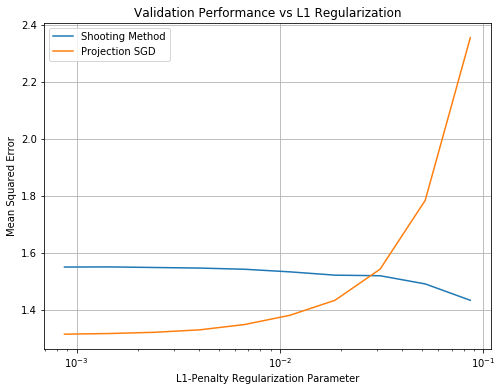

In [819]:
# Plot validation performance vs regularization parameter

fig, ax = plt.subplots(figsize = (8,6))
ax.grid()
ax.set_title("Validation Performance vs L1 Regularization")
ax.set_xlabel("L1-Penalty Regularization Parameter")
ax.set_ylabel("Mean Squared Error")

plt.semilogx(reg_vals, loss_shooting, label = 'Shooting Method')
plt.semilogx(reg_vals, loss_SGD_list, label = 'Projection SGD')
plt.legend(loc='upper left')
plt.show();

In [824]:
# Report the best 

lambda_best_SGD = reg_vals[np.argmin(loss_SGD_list)]
theta0 = get_ridge_solution(X_training,y_training, l2_reg = 0.01)
theta_positive_0 = [w if w >= 0 else 0 for w in theta0]
theta_negative_0 = [-w if w < 0 else 0 for w in theta0]
theta_positive_ini=theta_positive_0
theta_negative_ini = theta_negative_0
theta_lasso_SGD_best = projection_SGD_split(X_training, y_training, theta_positive_ini, theta_negative_ini, lambda_reg=lambda_best_SGD, alpha = 0.01) 
print('Best lambda for SGD is {0} with loss {1}'.format(lambda_best_SGD, np. min(loss_SGD_list)))

(SGD) Ran for 291 epochs. Loss:357.68512468060527 Lambda: 0.0008706247236908194
Best lambda for SGD is 0.0008706247236908194 with loss 1.3148878385065137


### 2

In [834]:
def compare_parameter_vectors(pred_fns):

	fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize = (20,20))
	num_ftrs = len(pred_fns[0]["coefs"])
	for i in range(len(pred_fns)):
		title = pred_fns[i]["name"]
		coef_vals = pred_fns[i]["coefs"]
		axs[i].bar(range(num_ftrs), coef_vals, color = "tab:purple")
		axs[i].set_xlabel('Feature Index')
		axs[i].set_ylabel('Parameter Value')
		axs[i].set_title(title)

	fig.subplots_adjust(hspace=0.4)
	return fig

In [844]:
theta_SGD= projection_SGD_split(X_training, y_training, theta_positive_0, theta_negative_0, lambda_reg=lambda_best_SGD, alpha = 0.001, num_iter = 1000)
pred_fns = []
pred_fns.append({"name": "Target Function", "coefs": coefs_true, "preds": target_fn(x)})
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
pred_fns.append({"name":"SGD Best L1_reg = "+str(lambda_best_SGD),
                     "coefs":theta_SGD,
                     "preds": np.dot(X_validation, theta_SGD) })
lambda_best_Shooting = reg_vals[np.argmin(loss_shooting)]
print('Best lambda for Shooting is {0} with loss {1}'.format(lambda_best_Shooting, np.min(loss_shooting)))
theta_Shooting = shooting_algorithm(X_training, y_training, w0=None, l1_reg = lambda_best_Shooting, max_num_epochs = 1000, min_obj_decrease=1e-8, random =False)
pred_fns.append({"name":"Shooting Algorithm Best L1_reg="+str(lambda_best_Shooting ),
                     "coefs":theta_Shooting,
                     "preds": np.dot(X_validation, theta_Shooting) })


(SGD) Ran for 1000 epochs. Loss:3.7715518535418284 Lambda: 0.0008706247236908194
Best lambda for Shooting is 0.08639124693688117 with loss 1.43361972223609
Ran for 1000 epochs. Lowest loss: 3.517884112359817


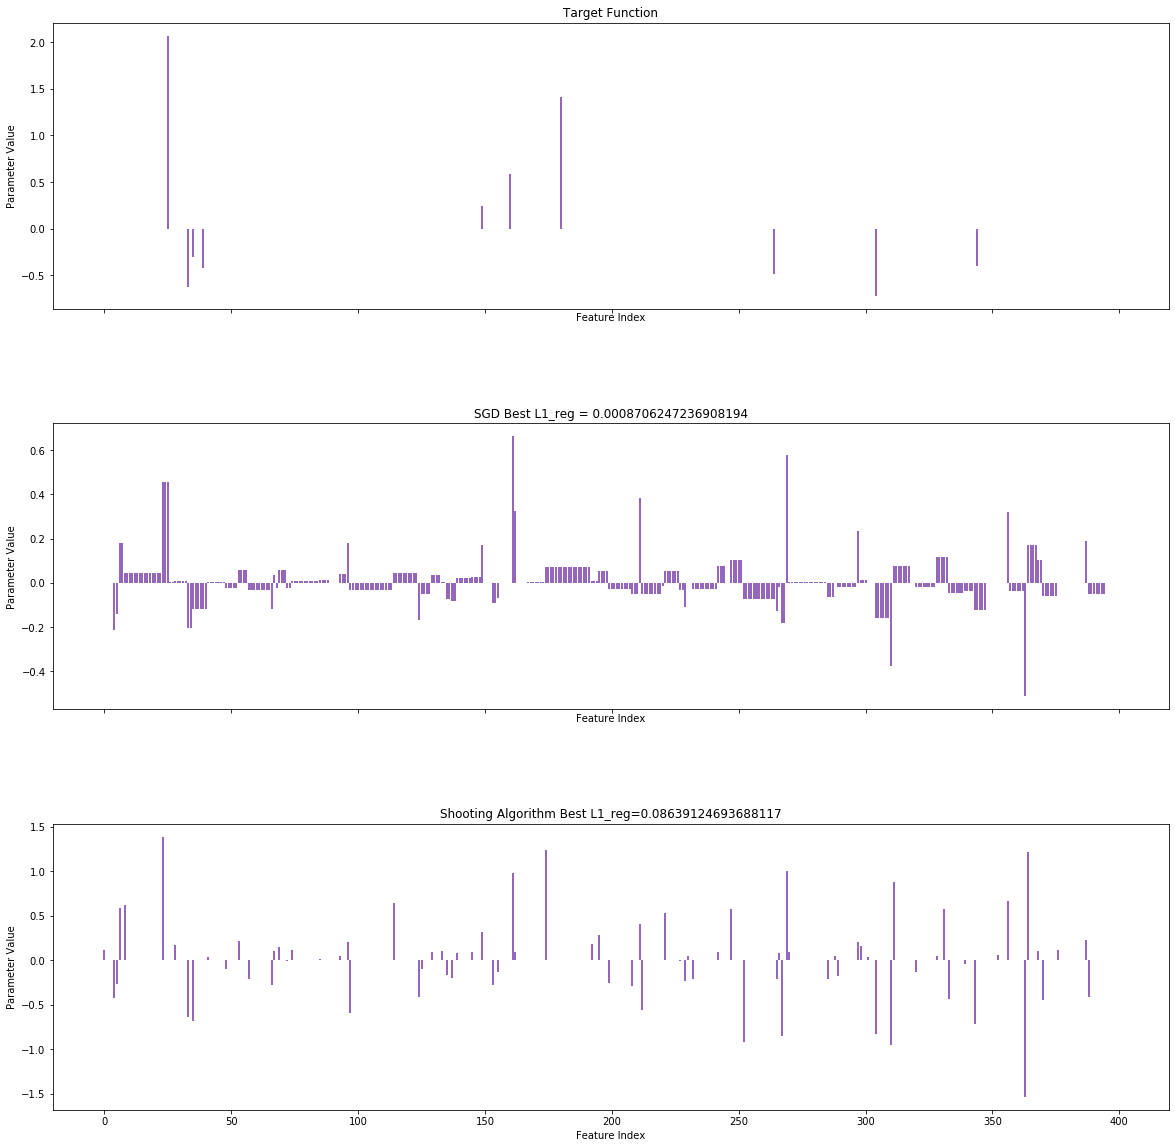

In [845]:
compare_parameter_vectors(pred_fns);

Best lambda for SGD is 0.0008706247236908194

Best lambda for Shooting is 0.08639124693688117

We could see that the SGD algorithm has more non-zero parameters, so the shooting algorithm is more sparse than the SGD algorithm.